In [75]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Dense, Input 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import EfficientNetB4, MobileNetV2
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam, SGD 
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import argparse

import os
from os import path
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

from imutils import paths
import cv2

import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
model_type='mobilenetv2'

first_time_training=True

PROJECT_PATH = os.getcwd()
print('PROJECT_PATH: ', PROJECT_PATH)

ACCURACY_LOSS_OUPUT_FILE = os.path.join(PROJECT_PATH , 'log/'+model_type+'/'+model_type+'.jpg')
print('ACCURACY_LOSS_OUPUT_FILE: ', ACCURACY_LOSS_OUPUT_FILE)

TARGET_CLASSIFICATION_MODEL = os.path.join(PROJECT_PATH , 'trained_models/'+model_type+'/'+model_type+'.h5')
print('TARGET_CLASSIFICATION_MODEL: ', TARGET_CLASSIFICATION_MODEL)

CHECKPOINT_PATH = os.path.join(PROJECT_PATH , 'checkpoints/'+model_type+'/'+model_type+'.h5')
print('CHECKPOINT_PATH: ', CHECKPOINT_PATH)

LOGFILE_PATH = os.path.join(PROJECT_PATH , 'log/'+model_type+'/'+model_type+'.csv')
print('LOGFILE_PATH: ', LOGFILE_PATH)

PROJECT_PATH:  /Users/alexei/marmitoph_transfer_learning
ACCURACY_LOSS_OUPUT_FILE:  /Users/alexei/marmitoph_transfer_learning/log/mobilenetv2/mobilenetv2.jpg
TARGET_CLASSIFICATION_MODEL:  /Users/alexei/marmitoph_transfer_learning/trained_models/mobilenetv2/mobilenetv2.h5
CHECKPOINT_PATH:  /Users/alexei/marmitoph_transfer_learning/checkpoints/mobilenetv2/mobilenetv2.h5
LOGFILE_PATH:  /Users/alexei/marmitoph_transfer_learning/log/mobilenetv2/mobilenetv2.csv


In [77]:
sys.path.append(PROJECT_PATH)
import computer_vision_lib  
from computer_vision_lib import *

# **Load the Dataset**

In [78]:
data_dir = 'datasets/data'
filename = os.path.join(os.getcwd(), data_dir, "input_data.csv")

df = pd.read_csv(filename)
df['photo'] = df['photo'].apply(lambda x: os.path.join( data_dir, x))
df['photo'] = df['photo'].str.replace(r'\'', '_')
df['label'] = df['label'].str.replace(r'\'', '_')

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_validation_test_split(df, df_validation_size= 0.01, df_test_size = 0.01):
  # Split Test vs (Train/Validation) sets
  y = df['label']
  stratified_split = StratifiedShuffleSplit(n_splits=2, test_size =df_test_size)
  for train_index, test_index in stratified_split.split(df, y):
      df_train_val, df_test = df.iloc[train_index].copy(), df.iloc[test_index].copy()
      
  # Split Train vs Validation sets
  y_train_val = df_train_val['label']

  stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=df_validation_size/(1-df_test_size))
  for train_index, test_index in stratified_split.split(df_train_val, y_train_val):
      df_train, df_validation = df_train_val.iloc[train_index].copy(), df_train_val.iloc[test_index].copy()

  return df_train, df_validation, df_test

In [80]:
df_train, df_validation, df_test = train_validation_test_split(df, df_validation_size= 0.1, df_test_size = 0.1)
    
print(f"Length of the train set : {len(df_train)}")
print(f"Length of the validation set : {len(df_validation)}")
print(f"Length of the test set : {len(df_test)}")

Length of the train set : 800
Length of the validation set : 100
Length of the test set : 100


In [81]:
IMAGE_SIZE = 224

def create_input_tensor(df, size):
  x = np.zeros((len(df), size, size, 3))
  for i, ind in enumerate(df.index):
    im = cv2.imread(df['photo'].loc[ind])
    x[i] = tf.image.resize(im, (size, size))
  x /= 255
  return x


x_train = create_input_tensor(df_train, IMAGE_SIZE)
x_validation = create_input_tensor(df_validation, IMAGE_SIZE)
x_test = create_input_tensor(df_test, IMAGE_SIZE)

In [82]:
labels = df['label'].unique()
# Number of classes
NUM_CLASSES = len(labels)
print(NUM_CLASSES)

dict_num_to_label = {i:lab for i, lab in enumerate(labels)}
dict_label_to_num = {lab:i for i, lab in enumerate(labels)}

10


In [83]:
def get_encoded_target(df, dict_label_to_num):
  NUM_CLASSES = len(dict_label_to_num.keys())
  y = df['label'].apply(lambda x: dict_label_to_num[x])
  y = tf.keras.utils.to_categorical(y, NUM_CLASSES)
  return y

y_train = get_encoded_target(df_train, dict_label_to_num)
y_validation = get_encoded_target(df_validation, dict_label_to_num)
y_test = get_encoded_target(df_test, dict_label_to_num)

In [84]:
print("Taille de y_train : {}".format(y_train.shape))
print("Taille de y_validation : {}".format(y_validation.shape))
print("Taille de y_test : {}".format(y_test.shape))

Taille de y_train : (800, 10)
Taille de y_validation : (100, 10)
Taille de y_test : (100, 10)


# **Make Predictions**

In [85]:
print('Loading the best model...', CHECKPOINT_PATH)
t0 = datetime.datetime.now()
model = tf.keras.models.load_model(CHECKPOINT_PATH)
t1 = datetime.datetime.now()
print('time to load the model: ', (t1-t0))

Loading the best model... /Users/alexei/marmitoph_transfer_learning/checkpoints/mobilenetv2/mobilenetv2.h5
time to load the model:  0:00:02.752892


In [86]:
# make predictions on the testing set
print("[INFO] evaluating network on the validation dataset...")
model.evaluate(x_validation, y_validation,verbose=0)


[INFO] evaluating network on the validation dataset...


[1.667973279953003, 0.8799999952316284]

In [87]:
print("[INFO] evaluating network on the test dataset...")
model.evaluate(x_test, y_test,verbose=0)

[INFO] evaluating network on the test dataset...


[1.7143763303756714, 0.8600000143051147]

# **Testing on one image from the test set**

flatten the image
image.shape (150528, 1)
reshape the image to be similar to the input feature vector
image.shape (1, 224, 224, 3)
-----------------------------------------
prediction time :  0:00:00.752943
Food label :  jambons secs
Predicted food :  jambons secs
Confidence :  0.68887395
-----------------------------------------


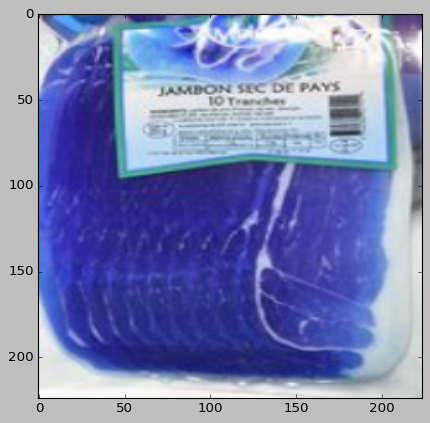

In [88]:
index = 34
test_image = x_test[index]

plt.imshow(test_image)
reshaped_image = computer_vision_lib.reshape_image_for_neural_network_input(test_image,IMAGE_SIZE=224, 
                                                                                   normalize=False)
t0 = datetime.datetime.now()
prediction_array = model.predict(reshaped_image)
t1 = datetime.datetime.now()
print('-----------------------------------------')
print ("prediction time : ", t1-t0)
print ("Food label : ", dict_num_to_label[np.argmax(y_test[index])])
print ("Predicted food : ", dict_num_to_label[np.argmax(prediction_array[0])])
print ("Confidence : ", prediction_array[0][np.argmax(prediction_array[0])])
print('-----------------------------------------')


# **Testing with the whole dataset**

In [89]:
testLabels = df_test['label'].values

In [90]:
prediction_array_all_test_dataset = model.predict(x_test, verbose=1)
predicted_labels_all_test_dataset = np.argmax(prediction_array_all_test_dataset, axis=1)

print(classification_report(y_test.argmax(axis=1), predicted_labels_all_test_dataset,target_names=np.unique(testLabels)))


4/4 [==============================] - 1s 300ms/step
                                                 precision    recall  f1-score   support

                                           chia       0.71      1.00      0.83        10
chips de pommes de terre à l_huile de tournesol       0.91      1.00      0.95        10
                                   cordons bleu       1.00      0.70      0.82        10
                   céréales pour petit déjeuner       1.00      0.80      0.89        10
                                 jambons blancs       0.89      0.80      0.84        10
                                   jambons secs       1.00      0.70      0.82        10
                                   pains de mie       1.00      0.60      0.75        10
                                pruneaux d_agen       0.71      1.00      0.83        10
                                      spiruline       1.00      1.00      1.00        10
                      yaourts au lait de brebis       0.

In [91]:
model_confusion_matrix = confusion_matrix(y_test.argmax(axis=1), predicted_labels_all_test_dataset)
print("model_confusion_matrix: \n",model_confusion_matrix)


model_confusion_matrix: 
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 1  0  7  0  0  0  0  0  0  2]
 [ 0  0  0  8  0  0  0  2  0  0]
 [ 2  0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  1  7  0  0  0  2]
 [ 1  1  0  0  0  0  6  2  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


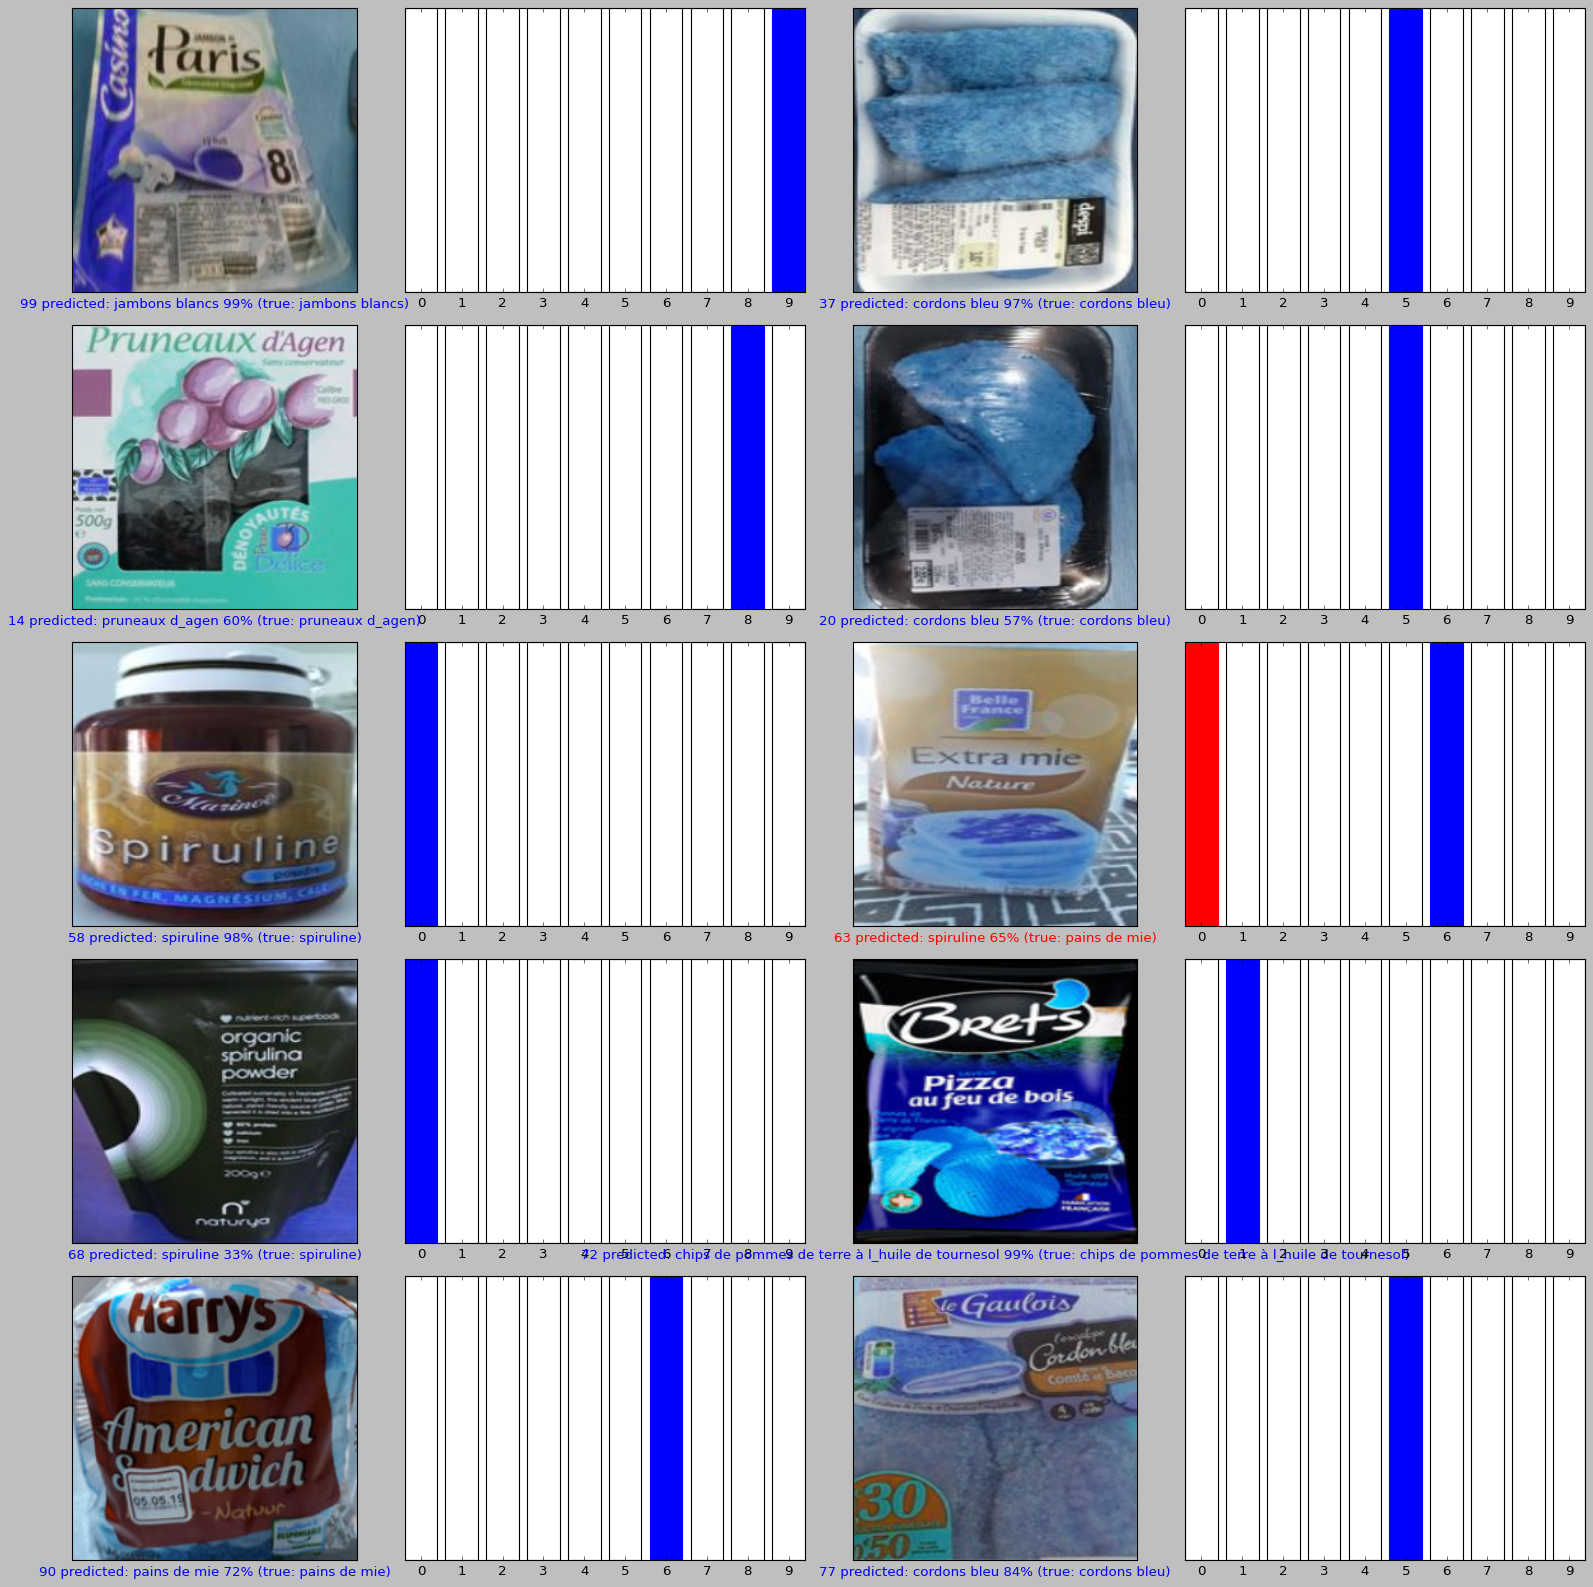

In [92]:
computer_vision_lib.plot_food_sample_predictions_v2(x_test, y_test, testLabels, prediction_array_all_test_dataset, num_rows = 5, num_cols = 2, width=20, height=20, is_random=True, plot_bars=True)


# **Testing on downloaded image**

None
(224, 224)
RGB
(224, 224, 3)
(224, 224, 3)


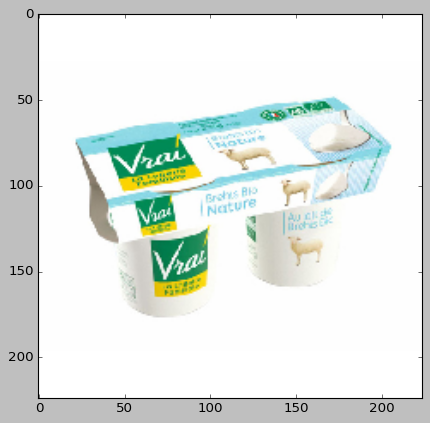

In [101]:
from PIL import Image

path = os.path.join(PROJECT_PATH , 'test-images/yaourt_brebis.jpg')
test_image = Image.open(path)

IMAGE_SIZE=224

test_image = test_image.resize((IMAGE_SIZE, IMAGE_SIZE))

print(test_image.format)
print(test_image.size)
print(test_image.mode)
test_image = np.array(test_image)
print (test_image.shape)
if (test_image.shape[2]>3): #sometime the image comes with RGBA with 4 channels
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGRA2BGR)
print (test_image.shape)
x=plt.imshow(test_image)

In [102]:
reshaped_test_image = computer_vision_lib.reshape_image_for_neural_network_input(test_image, IMAGE_SIZE=224,normalize=True)
prediction_my_image = model.predict(reshaped_test_image)
print(f'Prediction : {dict_num_to_label[np.argmax(prediction_my_image)]}')


flatten the image
image.shape (150528, 1)
reshape the image to be similar to the input feature vector
image.shape (1, 224, 224, 3)
Prediction : yaourts au lait de brebis


In [70]:
def top_five(prediction_my_image, class_dict):
    sorted_array=np.argsort(prediction_my_image)[0][-5:]
    sorted_array=np.flip(sorted_array)
    sorted_array
    for s in sorted_array:
        print('id: %3d, brand:%-10s, confidence: %6.3f'%(s,class_dict[s],prediction_my_image[0,s]))

In [71]:
top_five(prediction_my_image, dict_num_to_label)

id:   7, brand:yaourts au lait de brebis, confidence:  0.855
id:   9, brand:jambons blancs, confidence:  0.097
id:   0, brand:spiruline , confidence:  0.011
id:   6, brand:pains de mie, confidence:  0.009
id:   4, brand:chia      , confidence:  0.008


number of misclassications:  11
number of images: 75
rate of misclassications:  14.666666666666666 %
{2: ['cordons bleu', 'jambons blancs'], 4: ['cordons bleu', 'spiruline'], 12: ['jambons secs', 'jambons blancs'], 20: ['jambons secs', 'jambons blancs'], 21: ['jambons secs', 'jambons blancs'], 32: ['pains de mie', 'spiruline'], 37: ['chia', 'spiruline'], 41: ['pruneaux d_agen', 'spiruline'], 54: ['pruneaux d_agen', 'yaourts au lait de brebis'], 66: ['chia', 'spiruline'], 69: ['jambons secs', 'jambons blancs']}


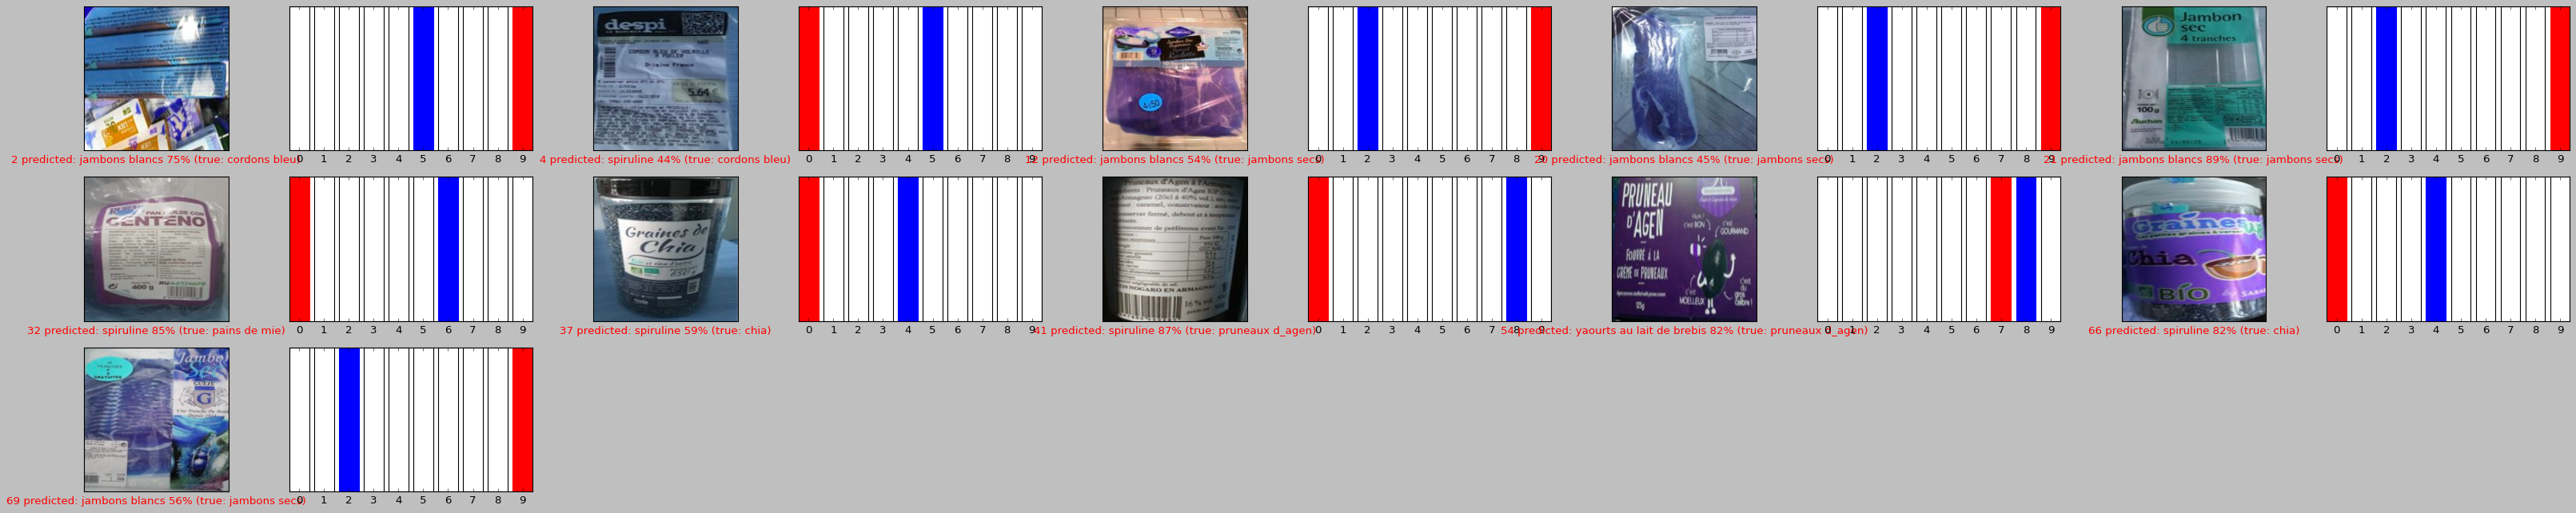

time to find misclassifications:  0:00:02.300068


In [72]:
t0=datetime.datetime.now()
ms_test = computer_vision_lib.plot_misclassifications(
    x_test, 
    y_test, 
    testLabels, 
    prediction_array_all_test_dataset, 
    num_rows =15 , num_cols=5, width=40, height=40, 
    is_random=False, plot_bars=True)
t1=datetime.datetime.now()
print('time to find misclassifications: ',(t1-t0))

In [73]:
prediction_array_all_dev_dataset = model.predict(x_validation, verbose=1)

4/4 [==============================] - 1s 311ms/step


number of misclassications:  17
number of images: 75
rate of misclassications:  22.666666666666668 %
{4: ['pruneaux d_agen', 'chips de pommes de terre à l_huile de tournesol'], 8: ['céréales pour petit déjeuner', 'chia'], 14: ['spiruline', 'yaourts au lait de brebis'], 18: ['céréales pour petit déjeuner', 'yaourts au lait de brebis'], 21: ['cordons bleu', 'jambons blancs'], 28: ['céréales pour petit déjeuner', 'chia'], 29: ['pains de mie', 'yaourts au lait de brebis'], 34: ['chips de pommes de terre à l_huile de tournesol', 'spiruline'], 35: ['pains de mie', 'pruneaux d_agen'], 36: ['cordons bleu', 'jambons blancs'], 42: ['jambons secs', 'jambons blancs'], 45: ['céréales pour petit déjeuner', 'chia'], 47: ['pruneaux d_agen', 'jambons blancs'], 52: ['chia', 'yaourts au lait de brebis'], 53: ['jambons secs', 'pruneaux d_agen'], 60: ['cordons bleu', 'céréales pour petit déjeuner'], 66: ['spiruline', 'céréales pour petit déjeuner']}


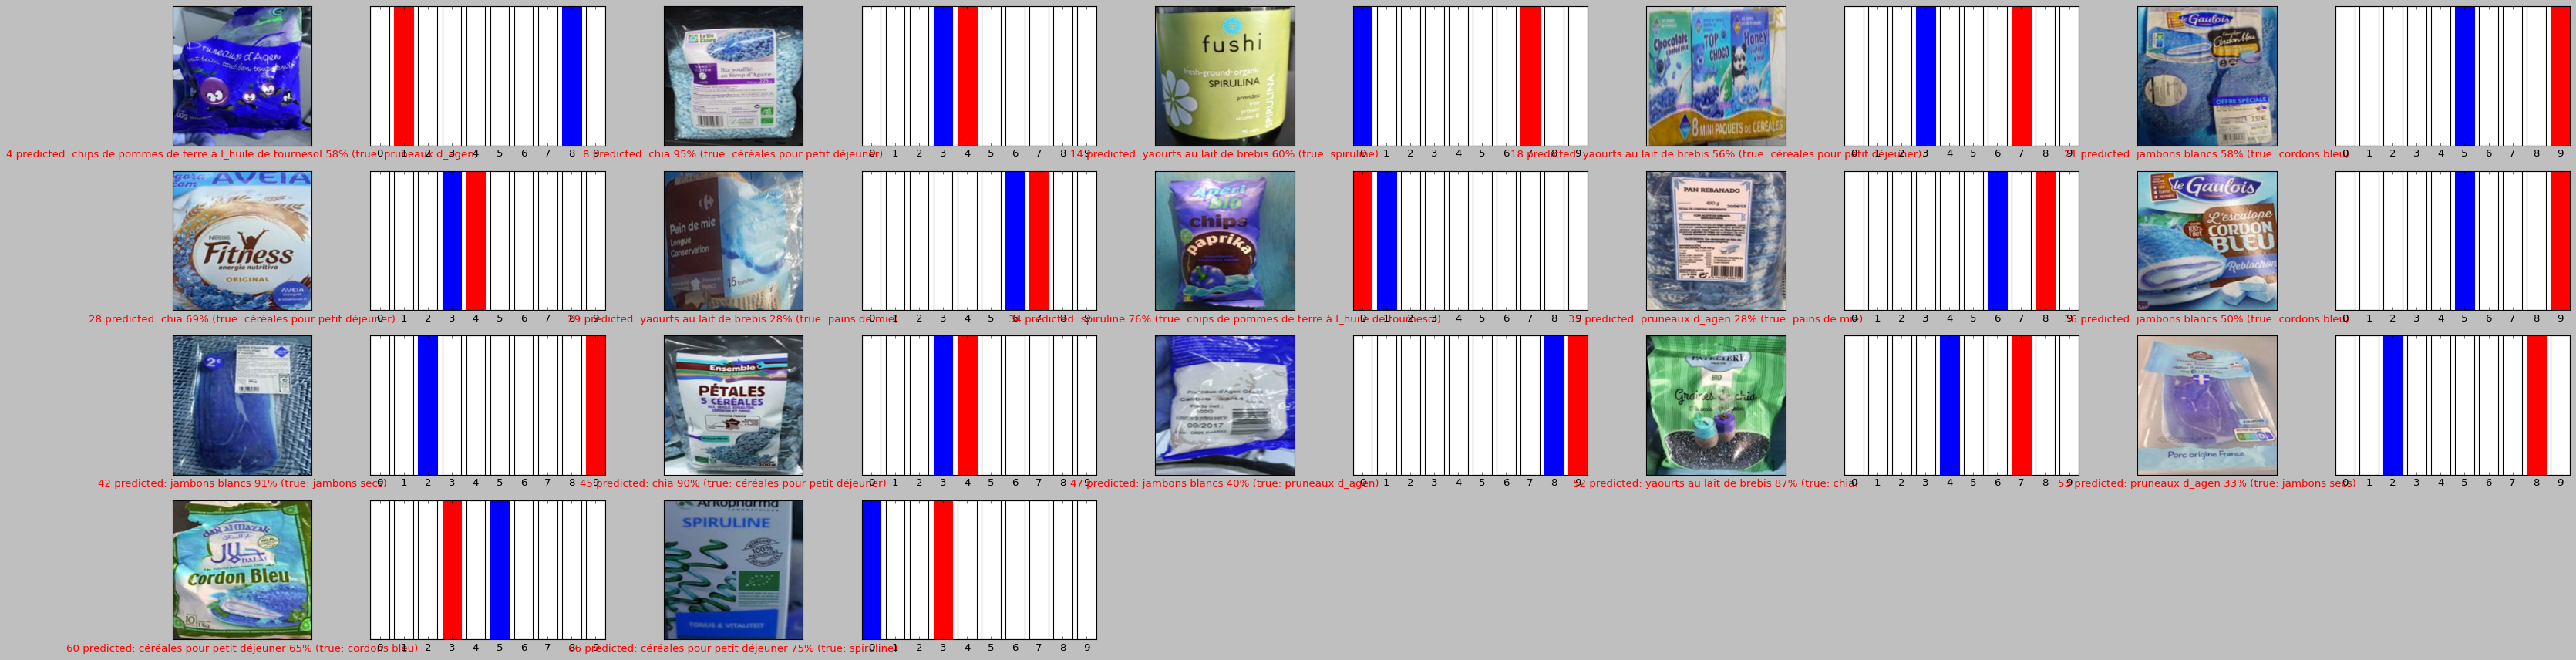

time to find misclassifications:  0:00:03.077336


In [74]:
t0=datetime.datetime.now()
devLabels = df_validation['label'].values
ms_dev = computer_vision_lib.plot_misclassifications(x_validation, y_validation, devLabels, prediction_array_all_dev_dataset, num_rows =15 , num_cols=5, width=40, height=40, is_random=False, plot_bars=True)
t1=datetime.datetime.now()
print('time to find misclassifications: ',(t1-t0))